In [35]:
url_init = 'https://www.alphavantage.co/query'

params_url={
    'function': 'CASH_FLOW', #'INCOME_STATEMENT',
    'symbol': 'AAPL',
    'apikey': 'ED6D6BFLZVWKAEG8',
}

class Config():
    future_horison = 10

conf = Config() 


In [14]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [15]:
import requests
from urllib.parse import urlparse, urlunparse


def comlete_url_params(url, params_url={}):
    uri = urlparse(url)
    query = uri.query
    for param in params_url:
        if len(query) > 0:
            query += "&"
        query += str(param) + "=" + str(params_url[param])
    url = urlunparse((uri.scheme, uri.netloc, uri.path, None, query, uri.fragment))
    return url


def to_snake_case(camel_string):
    snake_string = re.sub(r'(?<!^)(?=[A-Z])', '_', camel_string).lower()
    return snake_string

url = comlete_url_params(url_init, params_url)

r = requests.get(url)
data = r.json()

In [74]:
def convert_data(data_df):
    data_df.columns = [to_snake_case(col) for col in data_df.columns]
    for col in data_df.columns:
        
        if col == 'fiscal_date_ending':
            data_df[col] = pd.to_datetime(data_df[col])
        else:
            try:
                data_df[col] = pd.to_numeric(data_df[col], errors='coerce')
            except:
                pass
    return data_df

quarterlyReports = data['quarterlyReports']
annualReports = data['annualReports']

quarterly_reports_df = pd.DataFrame(quarterlyReports)
quarterly_reports_df = convert_data(quarterly_reports_df)
quarterly_reports_df = quarterly_reports_df.sort_values(by='fiscal_date_ending')

annual_reports_df = pd.DataFrame(annualReports)
annual_reports_df = convert_data(annual_reports_df)
annual_reports_df = annual_reports_df.sort_values(by='fiscal_date_ending')

In [89]:
def get_owners_earnings(operating_cashflow, maintenance_capital_expenditure):
    owners_earnings = operating_cashflow - maintenance_capital_expenditure
    return owners_earnings
    

def get_free_cash_flow(operating_cashflow, capital_expenditures):
    free_cash_flow = operating_cashflow - capital_expenditures
    return free_cash_flow

def get_growth_rate(data_s: pd.Series, shift: int):
    data_prev_s = data_s.shift(shift)
    growth_rate = data_s / data_prev_s
    return growth_rate
    
    
annual_reports_df['free_cash_flow'] = annual_reports_df.apply(lambda x: get_free_cash_flow(x['operating_cashflow'], x['capital_expenditures']), axis=1)
annual_reports_df['operating_cashflow_growth_rate'] = get_growth_rate(annual_reports_df['operating_cashflow'], 1)
annual_reports_df['free_cash_flow_growth_rate'] = get_growth_rate(annual_reports_df['free_cash_flow'],1)

quarterly_reports_df['free_cash_flow'] = quarterly_reports_df.apply(lambda x: get_free_cash_flow(x['operating_cashflow'], x['capital_expenditures']), axis=1)
quarterly_reports_df['operating_cashflow_growth_rate'] = get_growth_rate(quarterly_reports_df['operating_cashflow'], 4)
quarterly_reports_df['free_cash_flow_growth_rate'] = get_growth_rate(quarterly_reports_df['free_cash_flow'], 4)

In [ ]:
quarterly_reports_df[['fiscal_date_ending', '']]

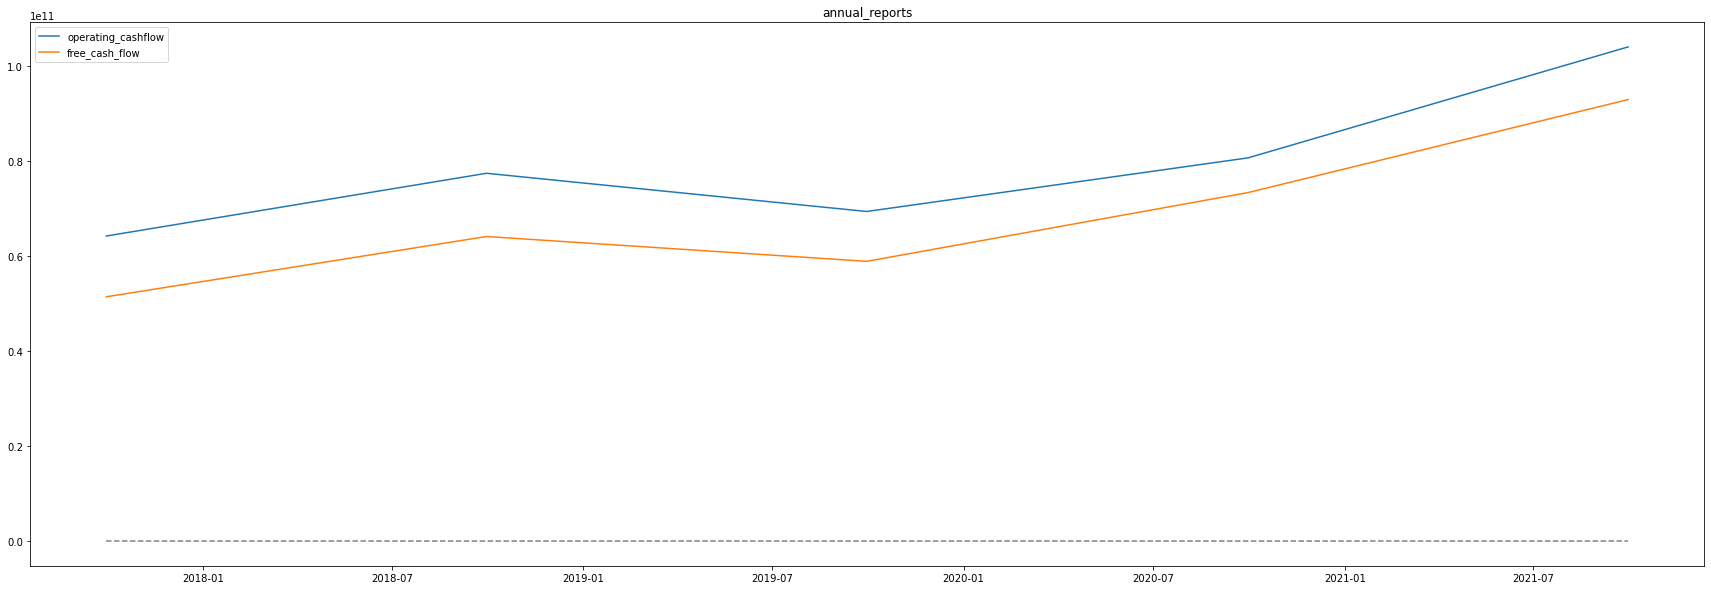

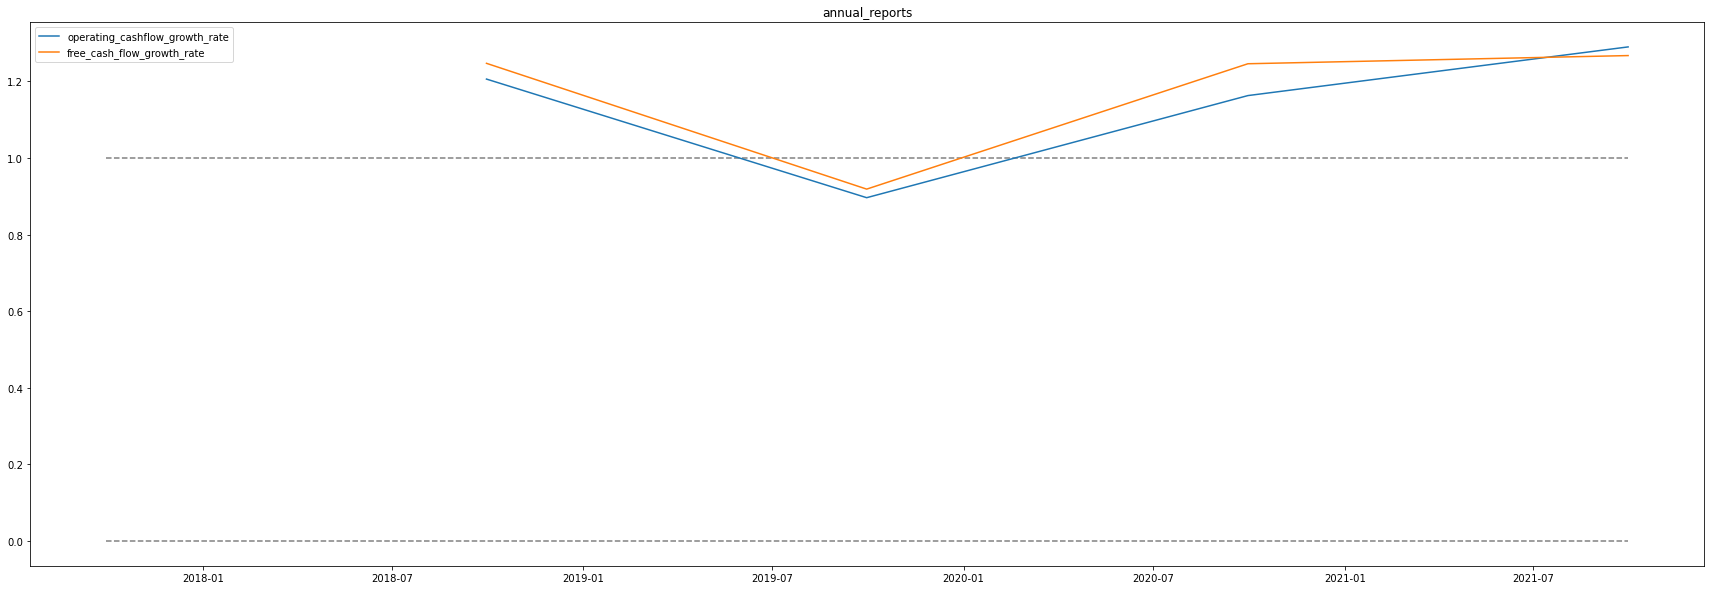

In [108]:

def plot_reports(reports_df, title = None):
#     all_data = pd.concat([reports_df['operating_cashflow'], 
#                           reports_df['free_cash_flow']])
    
    plt.figure(figsize=(30,10))
    # plt.ylim(min(0, all_data.min()), 
    #          max(0, all_data.max()))
    
    plt.plot(reports_df['fiscal_date_ending'], [0]*len(reports_df), '--', color = 'grey')
    plt.plot(reports_df['fiscal_date_ending'], reports_df['operating_cashflow'], label = 'operating_cashflow')
    plt.plot(reports_df['fiscal_date_ending'], reports_df['free_cash_flow'], label = 'free_cash_flow')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    
    
#     all_data = pd.concat([reports_df['operating_cashflow_growth_rate'], 
#                       reports_df['free_cash_flow_growth_rate']])

    plt.figure(figsize=(30,10))
#     plt.ylim(min(0, all_data.min()), 
#              max(0, all_data.max()))
    
    plt.plot(reports_df['fiscal_date_ending'], [0]*len(reports_df), '--', color = 'grey')
    plt.plot(reports_df['fiscal_date_ending'], [1]*len(reports_df), '--', color = 'grey')
    plt.plot(reports_df['fiscal_date_ending'], reports_df['operating_cashflow_growth_rate'], label = 'operating_cashflow_growth_rate')
    plt.plot(reports_df['fiscal_date_ending'], reports_df['free_cash_flow_growth_rate'], label = 'free_cash_flow_growth_rate')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

# plot_reports(quarterly_reports_df, 'quarterly_reports')
plot_reports(annual_reports_df, 'annual_reports')
